# Introduction to Equivariant Modelling in Materials Science

Author: 

Table of contents:
- [Why Equivariance?](#why-equivariance)
- [Symmetry in Materials Science](#symmetry-in-materials-science)
- [What is Equivariance?](#what-is-equivariance)
- [Building Equivariant NNs](#building-equivariant-nns)

In this tutorial we will explore the basics of equivariance (with some math) and also a concrete example of using Neural Networks equipped with equivariant layers. 
No mathematical background is required, we will also provide references for further reading in case you are interested.

# Why Equivariance?

Why should we use equivariance in the first place?
- The math involved is quite advanced,
- These methods are tough to implement,
- A unified implementation framework is also absent, though <a href="https://e3nn.org/">e3nn</a> has come quite far to solving this problem.

Despite these, it is encouraging to note that methods using equivariance are currently State-of-the-art (/ only models to do the task with a reasonable performance!) in many computational benchmarks with Materials Science applications, for e.g., Phonon Prediction [Fang et. al, 2024](https://doi.org/10.48550/arXiv.2403.11347), Phonons are quantized modes of vibrations in a crsytal lattice, and are important in understanding the thermal properties of materials; or Charge Density Prediction [Fu et. al, 2024](https://doi.org/10.48550/arXiv.2405.19276), charge density is essential to desnity functional theory and is used to derive *all* chemical properties of a material.
Such networks have also been used for generating unique 3D molecular structures ([Daigvane et. al, 2023](https://doi.org/10.48550/arXiv.2311.16199)).

<center>

| Metric (&uarr;) | Symphony (Uses Equivariancs) | G-SchNet (Does not use Equivariance) | G-SphereNet (Does not use Equivariance) |
| :--------------: | :--------------------------: | :----------------------------------: | :------------------------------------: |
| Validity using xyz2mol(%) | **83.5** | 74.97 | 26.92 |
| Uniqueness using xyz2mol(%) | **97.8** | 96.73 | 21.69 |

Results from Daigvane et. al, 2023 showing the superiority of Symphony over other methods in generating unique 3D molecular structures.
</center>

Apart from these explicit high-level results, Equivariant modelling is also highly data-efficient and also scales well compared to other methods.
We will explore these two points in some detail in the following sections, but these two advantages are very important, because data for Materials Science applications is often scarce and expensive to generate, and the computational cost of running simulations is very high.
Using equivariant models can help us save on both these fronts.

<center>

| Method | NMAE[\%] (&darr;) | Molecules/min. |
| :----: | :---------------: | :------------: |
| ChargE3Net (Partially Equivariant) | 0.196 ± 0.001 | 3.95 |
| InfGCN (Invariant) | 0.869 ± 0.002 | 72.00 |
| Best eSCN (Fully Equivariant) | **0.178 ± 0.001** | **125.29** |

Results from Fu et. al, 2024 showing the superiority and efficiency of their networks eSCN over other methods in predicting charge density.
</center>

With the proliferation of this knowledge, these models are now also being applied to Protein Folding ([AlphaFold-3](https://doi.org/10.1038/s41586-024-07487-w) which is again State-of-the-art (SOTA) on multiple benchmarks), and Materials Exploration / Generation on scale ([GNoME](https://doi.org/10.1038/s41586-023-06735-9)), these methods have equivariance at the very heart of their models.
Predictions from GNoME are also being used to synthesize materials with *specific properties*, which is a testament to the power of these methods.

<p float="left" align="center">
  <img src="assets/Intro-To-Equi-tutorial/AF3-generated-molecule.png" align="center" width="450"/>
  <img src="assets/Intro-To-Equi-tutorial/GNoME.png" align="center" width="400"/>
  <center> <i>Left</i>: A molecule generated by AlphaFold-3, <i>Right</i>: Impact of GNoME on Materials Discovery. </center>
</p>

Finally, we would also like to point out the methods involved are very interesting as they **supply** the model with information on **how** we represent 3D structures in real life and definitely warrant a read.

# Symmetry in Materials Science

To further the discussion on "Why?", we might just ask, why use any symmetry preserving methods at all?

To answer this, we need to understand that **we** model the physical world around us using coordinate systems and Euclidean Geometry, but, these are **non-existent** in the real world! 
There is no universal reference frame.
As such, we have already biased our models to a particular view, and we would like to remove these biases.
In certain applications, the effect of these biases is not pronounced, for example, if you have ever worked with images, we can make the model unbiased / **invariant** to rotations by simply rotating a few training images (or sometimes even this is not necessary).
Informally, this happens because the "number" of symmetries in the data is small, and we can easily account for them by augmenting the data.
However, in our case, making a model invariant to all possible rotations of a molecule would require us to do a massive amount of augmentation, about **500x**.
Thus, our use-case necessiates the use of some form of symmetry aware representations and/or models.

To be concrete, let's consider the example of a molecule.
Suppose we create a model to predict some property, say the charge of a Methane Molecule, based on it's 3D coordinates (might be a crappy model but atleast it will do something).

In [11]:
# Create a methane molecule
import numpy as np
np.random.seed(0)

from rdkit import Chem
from rdkit.Chem import AllChem

# Create a methane molecule from SMILES
methane_smiles = "C"
methane_molecule = Chem.MolFromSmiles(methane_smiles)
# Add hydrogens to the molecule
methane_molecule = Chem.AddHs(methane_molecule)
# Generate 3D coordinates
AllChem.EmbedMolecule(methane_molecule)
# Get the conformer to access 3D coordinates
conformer = methane_molecule.GetConformer()
# Extract coordinates into a NumPy array
num_atoms = methane_molecule.GetNumAtoms()
mol = np.zeros((num_atoms, 3))
for i in range(num_atoms):
    position = conformer.GetAtomPosition(i)
    mol[i] = [position.x, position.y, position.z]

# Display the Coordinates
print("Methane coordinates (in Ångströms):")
print(mol)

Methane coordinates (in Ångströms):
[[ 1.45387634e-03  1.54666437e-04  3.44865035e-03]
 [-5.94849027e-01 -2.15492110e-01  9.05941362e-01]
 [ 4.71560501e-01  9.98631355e-01  2.83340038e-02]
 [-6.78045304e-01 -3.36627563e-02 -8.58780716e-01]
 [ 7.99879954e-01 -7.49631155e-01 -7.89432993e-02]]


In [12]:
weights = np.random.randn(3)
print("Random weights: {}".format(weights))

def nn(mol, weights):
    return np.dot(mol, weights.T)

# do a forward pass
output = nn(mol, weights)
print("Output: {}".format(output))

Random weights: [1.76405235 0.40015721 0.97873798]
Output: [ 0.00600193 -0.24889632  1.25919851 -2.05009911  1.03379499]


Now suppose we rotate our molecule by 90 degrees about the x-axis, the charge of the molecule should not change, but our model will predict a different charge.
And although right now the weights are random, no matter how much data we train on, our model, by design, will always predict a different charge for the rotated molecule.

In [13]:
from scipy.spatial.transform import Rotation as R

# create a rotation matrix that rotates 90 degrees around the x-axis
r = R.from_rotvec(np.pi/2 * np.array([1, 0, 0]))
# rotate the molecule
mol_rotated = r.apply(mol)

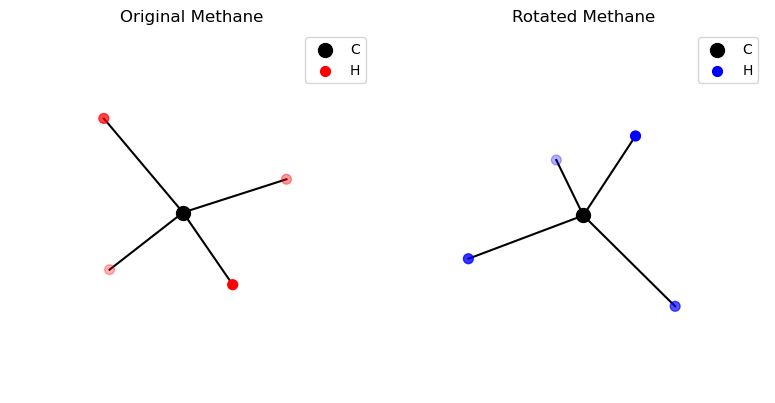

In [14]:
# Display original and rotated molecule
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(8, 4))

# Original molecule
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(mol[0, 0], mol[0, 1], mol[0, 2], c='k', s=100, label='C')
ax1.scatter(mol[1:, 0], mol[1:, 1], mol[1:, 2], c='r', s=50, label='H')
for i in range(1, 5):
    ax1.plot([mol[0, 0], mol[i, 0]], 
             [mol[0, 1], mol[i, 1]], 
             [mol[0, 2], mol[i, 2]], 'k-')
ax1.set_title('Original Methane')
ax1.legend()

# Rotated molecule
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(mol_rotated[0, 0], mol_rotated[0, 1], mol_rotated[0, 2], c='k', s=100, label='C')
ax2.scatter(mol_rotated[1:, 0], mol_rotated[1:, 1], mol_rotated[1:, 2], c='b', s=50, label='H')
for i in range(1, 5):
    ax2.plot([mol_rotated[0, 0], mol_rotated[i, 0]], 
             [mol_rotated[0, 1], mol_rotated[i, 1]], 
             [mol_rotated[0, 2], mol_rotated[i, 2]], 'k-')
ax2.set_title('Rotated Methane')
ax2.legend()

# Set equal aspect ratio
ax1.set_box_aspect((1,1,1))
ax2.set_box_aspect((1,1,1))
ax1.set_axis_off()
ax2.set_axis_off()

plt.tight_layout()
plt.show()

In [15]:
output_rotated = nn(mol_rotated, weights)
print("Rotated Output: {}".format(output_rotated))

print("Difference in output: {}".format(output - output_rotated))

Rotated Output: [ 1.33608958e-03 -1.62277410e+00  1.79791779e+00 -8.85407133e-01
  7.08927354e-01]
Difference in output: [ 0.00466584  1.37387778 -0.53871928 -1.16469198  0.32486764]


As an example let's try to make a model that is invariant to rotations about the x-axis. Simply enough we just have to sum across the varying axes!

In [16]:
new_weights = np.random.randn(num_atoms)

def invariant_nn(mol, weights):
    mol_ys = np.sum(mol[:, 1])
    mol_zs = np.sum(mol[:, 2])
    out = np.dot(mol[:, 0], weights.T) + mol_ys + mol_zs
    return out

In [17]:
output_invariant = invariant_nn(mol, new_weights)
output_rotated_invariant = invariant_nn(mol_rotated, new_weights)

print("Output: {}".format(output_invariant))
print("Rotated Output: {}".format(output_rotated_invariant))
print("Difference in output: {}".format(output_invariant - output_rotated_invariant))

Output: -2.3337733050769653
Rotated Output: -2.3337733050769653
Difference in output: 0.0


Nice, our model is now invariant to rotations about the x-axis, but what about the y-axis / z-axis? 
What about translations? 
What about reflections?
We can build a general model that is **invariant** to all these transformations, and we would direct the interested reader to [Ch.9 Input Data and Equivariances](https://dmol.pub/dl/data.html) for a detailed discussion on this.

# What is Equivariance?

In general, equivariance is a form of symmetry for functions.
Equivariance is easy to define and understand once we know what a **group** is and what a **representation** is.
This section involves some math but we will try to keep it as simple as possible.

#### Group
Intuitively a group consists of transformations and decides how they **compose and interact** with each other.
Formally, we say that a set of transformations $G$ is a group if:
- There exists an identity element $e \in G$ such that $eg = ge = g$ for all $g \in G$.
- For all $g \in G$, there exists an inverse $g^{-1}$ such that $gg^{-1} = g^{-1}g = e$.
- The composition of two transformations is also an transformation, i.e., for all $g, h \in G$, $gh \in G$.

#### Representation
This is a little more abstract than the notion of a group. 
The basis behind representation theory is to allow us to do abstract algebra (e.g. Matrix Multiplication) on some vector space. 
Thus a representation exists only in context of a group **and** a vector space.
A representation is like defining the **data-types**, it decides how a particular group element transforms a particular **type** of vector.
Formally, the representation of a group $G$ **on** a vector space $V$, written as $D(g, x)$ follows the following rules:
- Linearity, $D(g, x + y) = D(g, x) + D(g, y)$.
- Commutativity, $D(g, D(h, x)) = D(gh, x)$.

where $x, y \in V$ and $g, h \in G$.

However, we usually view the transformations in a group as matrices, so we also have this equivalent notation, written as $D(g) \times x$, such that:
- $D(g): V \rightarrow V$, $D(g) \in \mathbb{R}^{n \times n}$, where $n$ is the dimension of $V$.
- $D(g)D(h) = D(gh)$.

Let's take an example to understand these two concepts better.

In [18]:
# suppose our group consists of rotations of arbitrary rotations
# and our space is the Euclidean 3D space, 
# this is a valid group-and-vector-space combination

# create a rotation matrix
alpha, beta, gamma = np.random.rand(3) * 2 * np.pi
r = R.from_euler('xyz', [alpha, beta, gamma]) # D(g)

vec = np.random.randn(3) # v

vec_ = r.apply(vec) # D(g)v

This was a really simple example, however, it can get complicated if the representations are not just plain numbers!
For example, suppose we have a 2 atom system where we know the masses of the atoms and their velocities.
We couple this information into a single 8 dimensional vector ($[m_1, m_2, v_{1x}, v_{1y}, v_{1z}, v_{2x}, v_{2y}, v_{2z}] \in \mathbb{R}^8$).
Now, our system description is **still** in 3D but our representation is now 8D.

Also, we know that masses don't change under rotations (scalars, a particular **type of representation**), but velocities do (vector, another type of representation).
For now we also assume these two velocities are independent of each other (in practice this is not the case).
When we build a model, We need to encode this information to the model in some way.

Let's build a rotation matrix that obeys these properties.

In [19]:
m1_block = np.ones((1, 1)) # scalars don't change
m2_block = np.ones((1, 1))
v1_block = r # independent rotations
v2_block = r

row1 = np.concatenate([m1_block, np.zeros((1, 1)), np.zeros((1, 3)), np.zeros((1, 3))], axis=-1)
row2 = np.concatenate([np.zeros((1, 1)), m2_block, np.zeros((1, 3)), np.zeros((1, 3))], axis=-1)
row3 = np.concatenate([np.zeros((3, 1)), np.zeros((3, 1)), v1_block.as_matrix(), np.zeros((3, 3))], axis=-1)
row4 = np.concatenate([np.zeros((3, 1)), np.zeros((3, 1)), np.zeros((3, 3)), v2_block.as_matrix()], axis=-1)

R_prime = np.block([
    [row1],
    [row2],
    [row3],
    [row4]
])

print(R_prime)

[[ 1.          0.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.
   0.          0.        ]
 [ 0.          0.         -0.19272113  0.90154543  0.38739439  0.
   0.          0.        ]
 [ 0.          0.          0.71819132  0.39861012 -0.57036058  0.
   0.          0.        ]
 [ 0.          0.         -0.6686253   0.16830275 -0.72430269  0.
   0.          0.        ]
 [ 0.          0.          0.          0.          0.         -0.19272113
   0.90154543  0.38739439]
 [ 0.          0.          0.          0.          0.          0.71819132
   0.39861012 -0.57036058]
 [ 0.          0.          0.          0.          0.         -0.6686253
   0.16830275 -0.72430269]]


It is a block diagonal matrix.

#### Equivariance

Now we are ready to define equivariance.
Again, formally, given a function $f: V \rightarrow V'$, a group element $g \in G$, representations $D$ and $D'$ of $G$ on $V$ and $V'$ respectively, we say that $f$ is equivariant to $G$ if for all $x \in V$, we have 
$$
f(D(g)x) = D'(g)f(x)
$$

That was really abstract, let's break it down.
Intuitively, we want our function to act on the transformed input in the same way as the original input.

But this is still quite abstract, consider this example to understand it better. 
Suppose we are working with 3D coordinates and $g$ just cycles the coordinates clockwise (permutation).
Then 
$$f([x, y, z]) = [z + y, x + z, x + y]$$ 
is equivarant to $g$, because 
$$f(g[x, y, z]) = f([z, x, y]) = [x + y, y + z, z + x]$$
$$g' f([x, y, z]) = g' [z + y, x + z, x + y] = [x + y, y + z, z + x]$$

where $g' = g$. (This is the same math that makes GNN layers permutationally equivariant).

In [20]:
def f(x: np.ndarray) -> np.ndarray:
    y = [x[1] + x[2], x[0] + x[2], x[0] + x[1]]
    return np.array(y)

v1 = np.array([1, 2, 3])
print(f"Vector (v1): {v1}")
permutation = np.array([[0, 1, 0], [1, 0, 0], [0, 0, 1]]) # Permutation matrix
print(f"Permutation matrix (g): \n{permutation}")
permuted_v1 = np.dot(permutation, v1) # Permutes the vector
print(f"Permuted vector (g*v1): {permuted_v1}")
out_permuted_f1 = f(permuted_v1)
print(f"Output on permuted vector f1(g*v1): {out_permuted_f1}")
out_f1 = f(v1)
permuted_out_f1 = np.dot(permutation, out_f1)
print(f"Output on vector g'f1(v1): {permuted_out_f1}")

Vector (v1): [1 2 3]
Permutation matrix (g): 
[[0 1 0]
 [1 0 0]
 [0 0 1]]
Permuted vector (g*v1): [2 1 3]
Output on permuted vector f1(g*v1): [4 5 3]
Output on vector g'f1(v1): [4 5 3]


Now, in principle we could just use these simple transformations to build equivariant models, but in practice, we have additional information, i.e., our inputs are limited to the Euclidean Equivariant Group.
We also need to make these learnable in some way.
This is where Equivariant Neural Networks come in.

# Building Equivariant NNs

For this tutorial let us consider the following two symmetries in the geometry of our input, **Rotations and Inversions (or parity)**.
By inversion, we mean how a particular object is transformed upon reflection.

We will also limit our discussion to learning (equivariant) polynomial functions, because:
1. They are easy to deal with,
2. They are very powerful and can approximate any function to arbitrary precision,
3. There is a rich source of theory backing them up.

(We will consider any $f : \mathbb{R}^n \rightarrow \mathbb{R}^m$ as a ploynomial map)

These equivariances are present everywhere in crystal lattices and can help us learn very powerful representations of the data.
(The two symmetries combined are included in a special group called **O(3)**.)

#### Irreducible Representations (Irreps)
To build such networks we need to also understand irreps.
Equivariant polynomials are closed under composition, addtion and cartesian product, i.e. result in an equivariant polynomial when combined using any of these operations.
Yet, something interesting happens when we consider the cartesian product.

Given two equivariant polynomial functions, $h$ and $f$, acting on $V$ and $V'$ respectively, with $D(g)$ and $D'(g)$ as the transformations, the function $h \otimes f$ is also equivariant, with $x \otimes y$ being transformed by $D(g) \otimes D'(g)$, i.e., 
$$
h(D(g)x) \otimes f(D'(g)y) = (D(g) \otimes D'(g))(h \otimes f)(x \otimes y)
$$

Note however, that $dim(D(g) \otimes D'(g)) = dim(D(g))*dim(D'(g))$, i.e., the dimensionality of the final representation is the **product** of the dimensions of the two representations.
This growth of dimensionality is problematic, and we need to find a way to **reduce** this dimensionality.
Also compositions are **necessary** to develop expressive polynomial functions, so this is not just out of mathematical curiosity.

**Irreps** are the solution to this problem.
Basically, it is possible to decompose a $x \otimes y$ where $x \in V$ and $y \in V'$ into a sum of **irreducible** representations, as follows - 
$$
x \otimes y = |d1 - d2| \oplus \ldots \oplus (d1 + d2)
$$
i.e., a sum of vectors with dimenionality ranging from $|d1 - d2|$ to $(d1 + d2)$; where $d1$ and $d2$ are the dimensions of the two representations.

#### E3 Equivariant NNs
With this we can finally build our equivariant neural network layer!